In [1]:
%matplotlib inline
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="1"; 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix,explained_variance_score
import time
from datetime import timedelta
import math
import pickle
import pandas
from datapipe import bin_ndarray
from skimage import io

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Input, Dense, Flatten, GlobalAveragePooling2D, Conv1D,Conv2D, MaxPooling2D,MaxPooling1D, Dropout, UpSampling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
def cropImage(imArr):
    (length, x, y, channel) = imArr.shape
    cropped = np.zeros((length, x+1, y+1, channel))
    for ind, im in enumerate(imArr):
        for rowind, row in enumerate(im):
            row1 = np.append(row,0)
            cropped[ind][rowind] = row1.reshape(y+1,1)
    return cropped

In [4]:
eye = io.imread('./data/eye.tif')
np.random.seed(42)
(length, lenx, leny) = eye.shape
print(eye.shape)
print(lenx,leny)

(21406, 59, 79)
59 79


In [13]:
#though I was going to do multiple in this file but maybe if I have multiple 
data =eye

In [14]:
num_data = len(data)
train_split = 0.8
num_train = int(train_split*num_data)
num_test = num_data - num_train
x_train = data[0:num_train].reshape(num_train, (lenx*leny))
x_test = data[(num_train):].reshape(num_test, (lenx*leny))

In [15]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [16]:
x_test_scaled = x_scaler.transform(x_test)

In [17]:
input_img = Input(shape=(lenx+1, leny+1, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (2, 2), activation='relu', padding='same')(input_img)
x = MaxPooling2D((3, 2), padding='same')(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(16, (2, 2), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (2, 2), activation='relu',padding='same')(x)
x = UpSampling2D((3, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [18]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 80, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 80, 64)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 40, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 40, 32)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 20, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 20, 16)        2064      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 10, 16)         0         
__________

In [19]:
print(lenx,leny)
x_train = np.ndarray.astype(x_train_scaled.reshape((num_train, lenx,leny,1)), np.float16)
x_test = np.ndarray.astype(x_test_scaled.reshape((num_test, lenx, leny, 1)), np.float16)
x_train = cropImage(x_train)
x_test = cropImage(x_test)
print(x_train.shape)

59 79
(17124, 60, 80, 1)


In [20]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [21]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [22]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [23]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [24]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]
print(x_train.shape)

(17124, 60, 80, 1)


In [25]:
%%time
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)

Train on 17124 samples, validate on 4282 samples
Epoch 1/50
17124/17124 [==============================] - 20s 1ms/step - loss: 0.5653 - val_loss: 0.5488

Epoch 00001: val_loss improved from inf to 0.54878, saving model to 23_checkpoint.keras
Epoch 2/50
17124/17124 [==============================] - 17s 1ms/step - loss: 0.5106 - val_loss: 0.5374

Epoch 00002: val_loss improved from 0.54878 to 0.53742, saving model to 23_checkpoint.keras
Epoch 3/50
17124/17124 [==============================] - 17s 1ms/step - loss: 0.4874 - val_loss: 0.5107

Epoch 00003: val_loss improved from 0.53742 to 0.51074, saving model to 23_checkpoint.keras
Epoch 4/50
17124/17124 [==============================] - 17s 1ms/step - loss: 0.4753 - val_loss: 0.5007

Epoch 00004: val_loss improved from 0.51074 to 0.50074, saving model to 23_checkpoint.keras
Epoch 5/50
17124/17124 [==============================] - 17s 1ms/step - loss: 0.4669 - val_loss: 0.4935

Epoch 00005: val_loss improved from 0.50074 to 0.49351, s

17124/17124 [==============================] - 18s 1ms/step - loss: 0.4390 - val_loss: 0.4641

Epoch 00042: val_loss improved from 0.46429 to 0.46412, saving model to 23_checkpoint.keras
Epoch 43/50
17124/17124 [==============================] - 18s 1ms/step - loss: 0.4389 - val_loss: 0.4640

Epoch 00043: val_loss improved from 0.46412 to 0.46403, saving model to 23_checkpoint.keras

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
Epoch 44/50
17124/17124 [==============================] - 18s 1ms/step - loss: 0.4388 - val_loss: 0.4640

Epoch 00044: val_loss improved from 0.46403 to 0.46401, saving model to 23_checkpoint.keras
Epoch 45/50
17124/17124 [==============================] - 18s 1ms/step - loss: 0.4388 - val_loss: 0.4640

Epoch 00045: val_loss improved from 0.46401 to 0.46400, saving model to 23_checkpoint.keras

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 46/50
17124/17124 [==============================

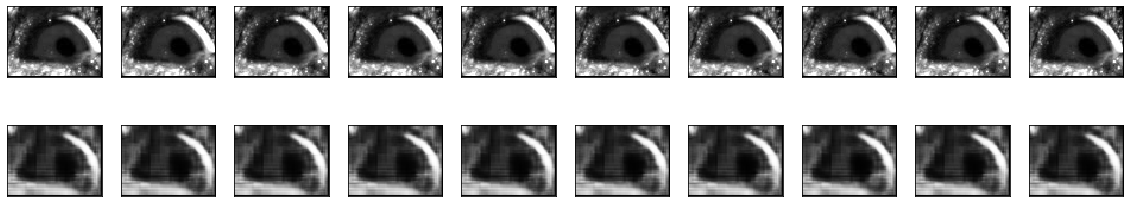

In [26]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i+600].reshape(lenx+1, leny+1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i+600].reshape(lenx+1, leny+1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
autoencoder.save('eyeEncoder.h5')